Epoch 1/10, Accuracy: 0.6058, Learning Rate: 0.100000
Epoch 2/10, Accuracy: 0.5276, Learning Rate: 0.095123
Epoch 3/10, Accuracy: 0.7002, Learning Rate: 0.090484
Epoch 4/10, Accuracy: 0.8109, Learning Rate: 0.086071
Epoch 5/10, Accuracy: 0.8225, Learning Rate: 0.081873
Epoch 6/10, Accuracy: 0.8250, Learning Rate: 0.077880
Epoch 7/10, Accuracy: 0.8267, Learning Rate: 0.074082
Epoch 8/10, Accuracy: 0.8286, Learning Rate: 0.070469
Epoch 9/10, Accuracy: 0.8303, Learning Rate: 0.067032
Epoch 10/10, Accuracy: 0.8315, Learning Rate: 0.063763

Test Accuracy: 0.8335


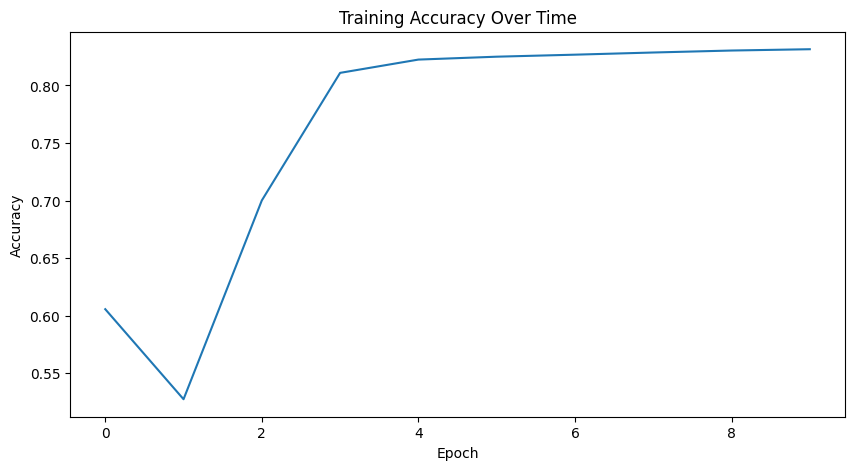

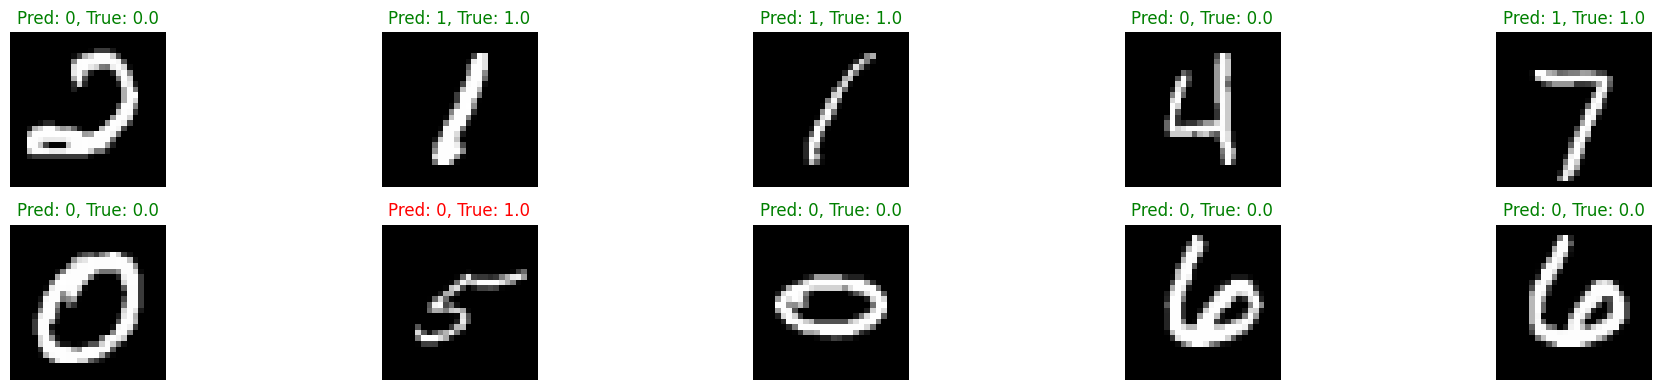

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

class EntropyBasedClassifier:
    def __init__(self, input_dim, learning_rate=0.01, delta=0.05):
        """
        Initialize the entropy-based classifier with dual-weight structure.
        
        Args:
            input_dim: Dimension of input features (784 for MNIST)
            learning_rate: Initial learning rate for parameter updates
            delta: Maximum allowed change in knowledge (z) between iterations
        """
        # Initialize model parameters
        # Shape [784, 1] for weights to properly handle batch operations
        # Use a scaling factor for weights (e.g., 0.01) to get small random values

        initializer = tf.keras.initializers.GlorotNormal()
        scale = 0.01
        self.w1 = tf.Variable(scale * initializer([28*28, 1]))
        self.G1 = tf.Variable(scale * initializer([28*28, 1]))
        self.b1 = tf.Variable(tf.zeros([1]))
        
        self.learning_rate = tf.Variable(learning_rate)
        self.delta = delta
        self.training_accuracy = []
        
    def compute_knowledge(self, x):
        """
        Compute knowledge using dual-weight structure: z = Σ(w1,j + G1,j)x_j + b1
        
        Args:
            x: Input features [batch_size, input_dim]
        Returns:
            z: Knowledge values [batch_size, 1]
            D: Activation values [batch_size, 1]
        """
        # Combine weights: shape [input_dim, 1]
        combined_weights = self.w1 + self.G1
        
        # Compute z: shape [batch_size, 1]
        z = tf.matmul(x, combined_weights) + self.b1
        
        # Compute activation D using sigmoid
        D = tf.sigmoid(z)
        
        return z, D
    
    def compute_entropy_gradient(self, z, D):
        """
        Compute the entropy gradient: ∂H(z)/∂z_k = -1/ln(2) * z_k * D_k * (1 - D_k)
        
        Returns gradient with shape [batch_size, 1]
        """
        return -1.0 / tf.math.log(2.0) * z * D * (1.0 - D)
    
    def enforce_z_constraint(self, z_new, z_old, updates):
        """
        Enforce the constraint |z_new - z_old| < delta by scaling updates if necessary
        """
        z_change = tf.abs(z_new - z_old)
        max_change = tf.reduce_max(z_change)
        
        if max_change > self.delta:
            scale_factor = self.delta / max_change
            return [update * scale_factor for update in updates]
        return updates
    
    @tf.function
    def train_step(self, x, y, z_previous):
        """
        Perform one training step using entropy-based updates
        
        Args:
            x: Input features [batch_size, input_dim]
            y: Labels [batch_size, 1]
            z_previous: Previous z values [batch_size, 1]
        """
        with tf.GradientTape(persistent=True) as tape:
            # Forward pass
            z_current, D = self.compute_knowledge(x)
            
            # Compute entropy gradient [batch_size, 1]
            entropy_grad = self.compute_entropy_gradient(z_current, D)
            mean_entropy_grad = tf.reduce_mean(entropy_grad)

            supervised_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(y,D))
            
            # Compute gradients with respect to parameters
            gradients = tape.gradient(z_current, [self.w1, self.G1, self.b1])
            sup_gradients = tape.gradient(supervised_loss, [self.w1, self.G1, self.b1])
            # Process each parameter's gradient separately with proper shapes
            # For w1 (shape [784, 1])
            w1_grad = gradients[0]  # Shape matches input features transposed
            # Reshape entropy_grad to [batch_size, 1]
            batch_size = tf.shape(x)[0]
            reshaped_entropy = tf.reshape(entropy_grad, [batch_size, 1])
            
            # Initialize updates to zeros with same shapes as parameters
            w1_update = tf.zeros_like(self.w1)
            G1_update = tf.zeros_like(self.G1)
            # Loop over each sample in the batch (for demonstration)
            for i in tf.range(batch_size):
                # Each sample's feature vector (reshaped to [input_dim, 1])
                sample_x = tf.reshape(x[i], [tf.shape(x)[1], 1])
                sample_entropy = reshaped_entropy[i]  # shape [1]
                # Update contributions for w1 and G1
                w1_update += -self.learning_rate * sample_entropy * sample_x / tf.cast(batch_size, tf.float32)
                G1_update += -self.learning_rate * sample_entropy * sample_x / tf.cast(batch_size, tf.float32)
        
            # For bias (simpler as it's just a scalar)
            b1_update = tf.broadcast_to(-self.learning_rate * mean_entropy_grad, self.b1.shape)
            alpha = 0.5
            w1_update += (-self.learning_rate * alpha * sup_gradients[0])
            G1_update += (-self.learning_rate * alpha * sup_gradients[1])
            b1_update += (-self.learning_rate * alpha * sup_gradients[2])
            updates = [w1_update, G1_update, b1_update]
            
            # Enforce z constraint
            updates = self.enforce_z_constraint(z_current, z_previous, updates)
            
            # Apply updates with correct shapes
            self.w1.assign_add(updates[0])
            self.G1.assign_add(updates[1])
            self.b1.assign_add(updates[2])
            
        # Compute accuracy
        predictions = tf.cast(D > 0.5, tf.float32)
        accuracy = tf.reduce_mean(tf.cast(predictions == y, tf.float32))
        
        return z_current, accuracy

    def adjust_learning_rate(self, accuracy, epochs, epoch):
        # Exponential decay: base_lr * exp(-decay_rate * epoch)
        base_lr = 0.1
        decay_rate = 0.05
        new_lr = base_lr * tf.math.exp(-decay_rate * tf.cast(epoch, tf.float32))
        self.learning_rate.assign(new_lr)

def prepare_mnist_data():
    """
    Prepare MNIST dataset for even/odd classification
    """
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    
    # Normalize and reshape data
    x_train = x_train / 255.0
    x_test = x_test/ 255.0
    
    # Flatten the images to be vectors
    x_train = x_train.reshape(-1, 28 * 28)
    x_test = x_test.reshape(-1, 28 * 28)

    # Convert the digit labels to even/odd labels:
    # Even -> 0, Odd -> 1
    y_train_even_odd = np.array([label % 2 for label in y_train])
    y_test_even_odd = np.array([label % 2 for label in y_test])

    x_train = tf.cast(x_train, tf.float32)
    y_train_even_odd = tf.cast(y_train_even_odd, tf.float32)
    x_test = tf.cast(x_test, tf.float32)
    y_test_even_odd = tf.cast(y_test_even_odd, tf.float32)
    
    return (x_train, y_train_even_odd), (x_test, y_test_even_odd)

def visualize_predictions(model, x_test, y_test, num_samples=10):
    """
    Visualize random test samples with predictions
    """
    indices = np.random.choice(len(x_test), num_samples, replace=False)
    
    plt.figure(figsize=(20, 4))
    for i, idx in enumerate(indices):
        plt.subplot(2, 5, i + 1)
        reshaped_img = tf.reshape(x_test[idx], (28, 28))
        plt.imshow(reshaped_img.numpy(), cmap='gray')

        
        z, D = model.compute_knowledge(tf.expand_dims(x_test[idx], 0))
        pred = int(D > 0.5)
        true_label = y_test[idx]
        
        color = 'green' if pred == true_label else 'red'
        plt.title(f'Pred: {pred}, True: {true_label}', color=color)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


def train_model(batch_size=32, epochs=10):
    """
    Train the entropy-based classifier
    """
    # Prepare data
    (x_train, y_train), (x_test, y_test) = prepare_mnist_data()
    
    # Initialize model
    model = EntropyBasedClassifier(input_dim=784)
    
    # Training loop
    num_batches = len(x_train) // batch_size
    
    for epoch in range(epochs):
        epoch_accuracy = []

        indices = tf.convert_to_tensor(np.random.permutation(len(x_train)), dtype=tf.int32)
        x_train_shuffled = tf.gather(x_train, indices)
        y_train_shuffled = tf.gather(y_train, indices)
        
        for batch in range(num_batches):
            start_idx = batch * batch_size
            end_idx = start_idx + batch_size
            
            batch_x = x_train_shuffled[start_idx:end_idx]
            batch_y = y_train_shuffled[start_idx:end_idx]
            
            # Initialize z_previous for first iteration
            if batch == 0 and epoch == 0:
                z_previous = tf.zeros([batch_size, 1])
            
            # Train step
            z_current, accuracy = model.train_step(
                batch_x, 
                tf.expand_dims(batch_y, 1),
                z_previous
            )
            
            z_previous = z_current
            epoch_accuracy.append(accuracy)
            
        # Compute epoch metrics
        avg_accuracy = tf.reduce_mean(epoch_accuracy)
        model.training_accuracy.append(avg_accuracy)
        model.adjust_learning_rate(avg_accuracy, epochs, epoch)
        
        print(f"Epoch {epoch + 1}/{epochs}, Accuracy: {avg_accuracy:.4f}, "
              f"Learning Rate: {model.learning_rate.numpy():.6f}")
    
    # Evaluate on test set
    z_test, D_test = model.compute_knowledge(x_test)
    test_pred = tf.cast(D_test > 0.5, tf.float32)
    test_accuracy = tf.reduce_mean(tf.cast(test_pred == tf.expand_dims(y_test, 1), 
                                         tf.float32))
    
    print(f"\nTest Accuracy: {test_accuracy:.4f}")
    
    # Visualize results
    plt.figure(figsize=(10, 5))
    plt.plot(model.training_accuracy)
    plt.title('Training Accuracy Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()
    
    visualize_predictions(model, x_test, y_test)
    
    return model

if __name__ == "__main__":
    model = train_model(epochs=10)